In [3]:
import json

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [4]:
with open("temp/tests-1666381736.json", "r") as f:
    real = json.load(f)

In [5]:
def plot(datas, labels, title, filename, save_file=True):
    for v in datas:
        plt.title(title)
        T = np.array(range(len(v))) / 60
        plt.plot(T, v)
        plt.grid()
        plt.xlabel("Time(s)")
        plt.ylabel("Distance(cm)")
    plt.legend(labels)
    if save_file:
        plt.savefig(filename, format="jpeg")
    plt.show()

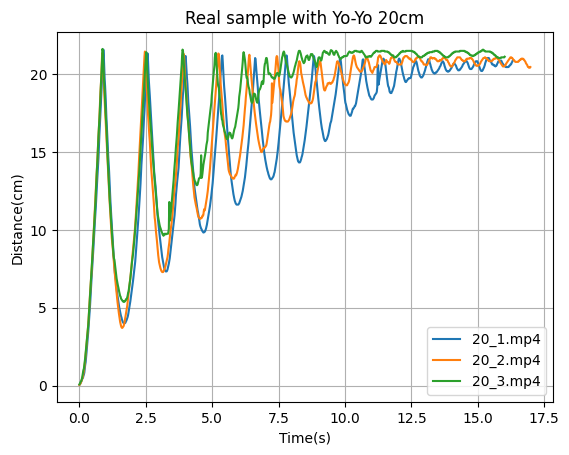

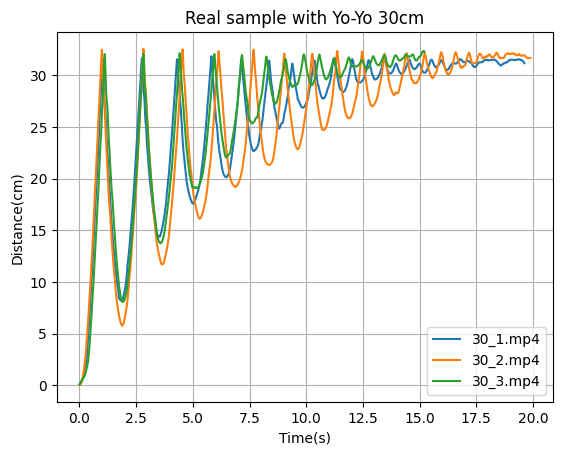

In [6]:
VIDEO_NAMES = [
    "20_1.mp4",
    "20_2.mp4",
    "20_3.mp4",
    "30_1.mp4",
    "30_2.mp4",
    "30_3.mp4"
]

plot(real[:3], VIDEO_NAMES[:3], "Real sample with Yo-Yo 20cm", "out/20cm.jpg", False)
plot(real[3:], VIDEO_NAMES[3:], "Real sample with Yo-Yo 30cm", "out/30cm.jpg", False)

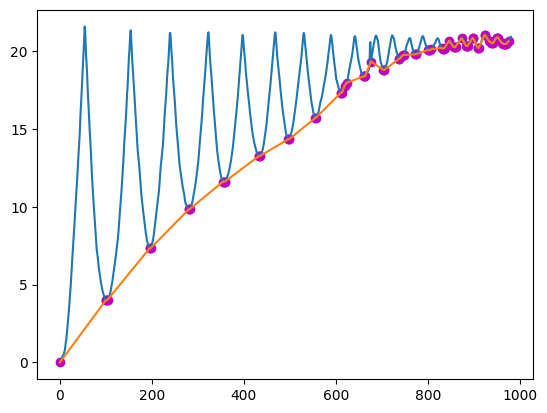

In [7]:
x_d = real[0]
points = [[0, 0]]
for i in range(1, len(x_d) - 1):
    if x_d[i - 1] >= x_d[i] <= x_d[i + 1]:
        points.append([i, x_d[i]])

points = np.array(points).T
plt.plot(x_d)
plt.scatter(*points, c="m")
plt.plot(*points)
plt.show()

## Simulation

In [8]:
from IPython.display import display, Math
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [9]:
# Constance
G = 981  # сm/s^2
L_30 = 30.5  # cm
L_21 = 21  # cm
R = 0.65 / 2  # cm
M = 63.85  # g
J = M * (2.2530346 ** 2)  # g cm^2

In [10]:
eta = M * R / (J + M * R)
gamma = eta / R
e_eq = 1 - 2 * eta
display(Math(r'\eta: %.4f' % eta))
display(Math(r'\gamma: %.4f' % gamma))
display(Math(r'e_{eq}: %.4f' % e_eq))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
dt = 0.01
phase_t_min = 0.1

A = np.array([[0, 1],
              [0, 0]])
B = np.array([0, -gamma * G])
T = np.arange(0, 200, dt)


def flip(t, y):
    return y[0]


flip.terminal = True
flip.direction = -1


def f(t, y):
    return A @ y + B


# Simulation of displacement of Yo-Yo for `x`
def simulation(length: int):
    vector = np.array([length / R, 0])
    t = T[0]
    t_prev = -np.inf

    y_axis = np.empty((2, 0))
    x_axis = np.empty(0)

    while t < T[-1] and (t - t_prev > phase_t_min):
        sol = solve_ivp(f, (t, T[-1]), vector, t_eval=T[np.searchsorted(T, t):], events=flip)
        y_axis = np.concatenate((y_axis, sol.y), axis=1)
        x_axis = np.concatenate((x_axis, sol.t))
        vector = sol.y[:, -1]
        vector[1] = -e_eq * vector[1]
        t_prev = t + np.pi / vector[1]
        t = sol.t[-1]

    return x_axis, y_axis

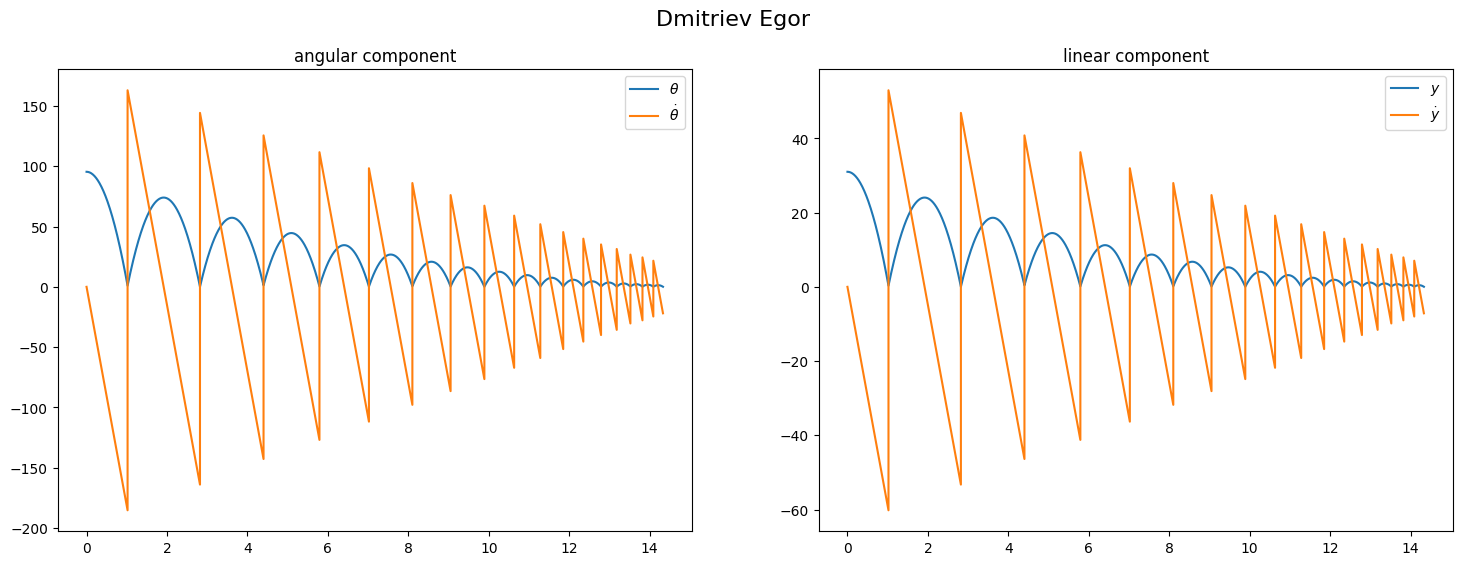

In [12]:
t_axis, x_axis_30 = simulation(31)

grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.5)
fig = plt.figure(figsize=(18, 6))
fig.suptitle("Dmitriev Egor", fontsize=16)
ax1 = plt.subplot(grid[:, 0], title='angular component')
ax2 = plt.subplot(grid[:, 1], title='linear component')

ax1.plot(t_axis, x_axis_30.T)
labels1 = [r'$\theta$', r'$\dot{\theta}$']
ax1.legend(labels1)

ax2.plot(t_axis, x_axis_30.T * R)
labels2 = [r'$y$', r'$\dot{y}$']
ax2.legend(labels2)

plt.show()

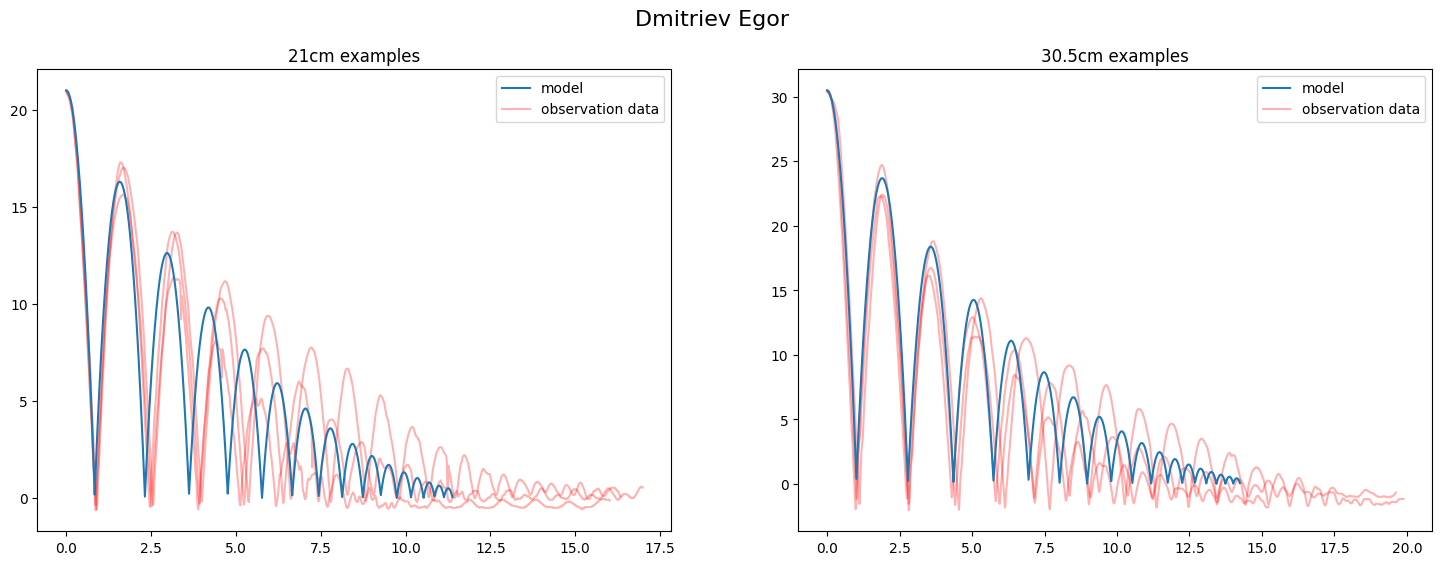

In [13]:
grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.5)
fig = plt.figure(figsize=(18, 6))
fig.suptitle("Dmitriev Egor", fontsize=16)

ax1 = plt.subplot(grid[:, 0], title=f'{L_21}cm examples')
data_t, data_20_X = simulation(L_21)
for i in range(0, 3):
    time_ref = np.array(range(len(real[i]))) / 60
    ax1.plot(time_ref, L_21 - np.array(real[i]), '-r', alpha=0.3)
ax1.plot(data_t, np.transpose(data_20_X)[:, 0] * R)

ax2 = plt.subplot(grid[:, 1], title=f'{L_30}cm examples')
data_t, data_30_X = simulation(L_30)
for i in range(3, 6):
    time_ref = np.array(range(len(real[i]))) / 60
    l_r, = ax2.plot(time_ref, L_30 - np.array(real[i]), '-r', alpha=0.3)
l_b, = ax2.plot(data_t, np.transpose(data_30_X)[:, 0] * R)

ax1.legend([l_b, l_r], ['model', 'observation data'])
ax2.legend([l_b, l_r], ['model', 'observation data'])
plt.show()

In [14]:
def simulation2(length: int):
    vector = np.array([length / R, 0])
    t = T[0]
    t_prev = -np.inf

    y_axis = np.empty((2, 0))
    x_axis = np.empty(0)

    while t < T[-1] and (t - t_prev > phase_t_min):
        sol = solve_ivp(f, (t, T[-1]), vector, t_eval=T[np.searchsorted(T, t):], events=flip)
        y_axis = np.concatenate((y_axis, sol.y), axis=1)
        x_axis = np.concatenate((x_axis, sol.t))
        vector = sol.y[:, -1]
        vector[1] = -e_eq * vector[1]
        t_prev = t + np.pi / vector[1] + np.pi / vector[1]
        t = sol.t[-1] + np.pi / vector[1] + np.pi / vector[1]

    return x_axis, y_axis

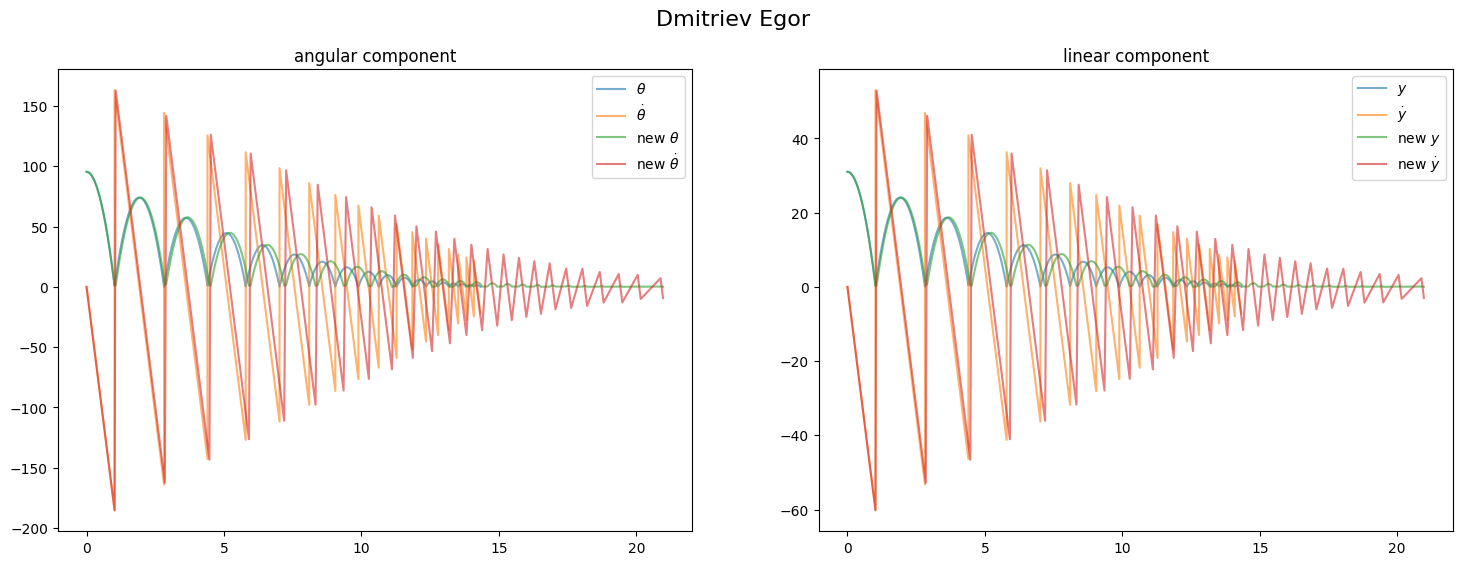

In [15]:
data_t, data_X = simulation(31)
data_t2, data_X2 = simulation2(31)

grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.5)
fig = plt.figure(figsize=(18, 6))
fig.suptitle("Dmitriev Egor", fontsize=16)

ax1 = plt.subplot(grid[0, 0], title='angular component')
ax1.plot(data_t, np.transpose(data_X), alpha=0.6)
ax1.plot(data_t2, np.transpose(data_X2), alpha=0.6)

ax2 = plt.subplot(grid[0, 1], title='linear component')
ax2.plot(data_t, np.transpose(data_X) * R, alpha=0.6)
ax2.plot(data_t2, np.transpose(data_X2) * R, alpha=0.6)

labels1 = [r'$\theta$', r'$\dot{\theta}$', r'new $\theta$', r'new $\dot{\theta}$']
labels2 = [r'$y$', r'$\dot{y}$', r'new $y$', r'new $\dot{y}$']

ax1.legend(labels1)
ax2.legend(labels2)
plt.show()

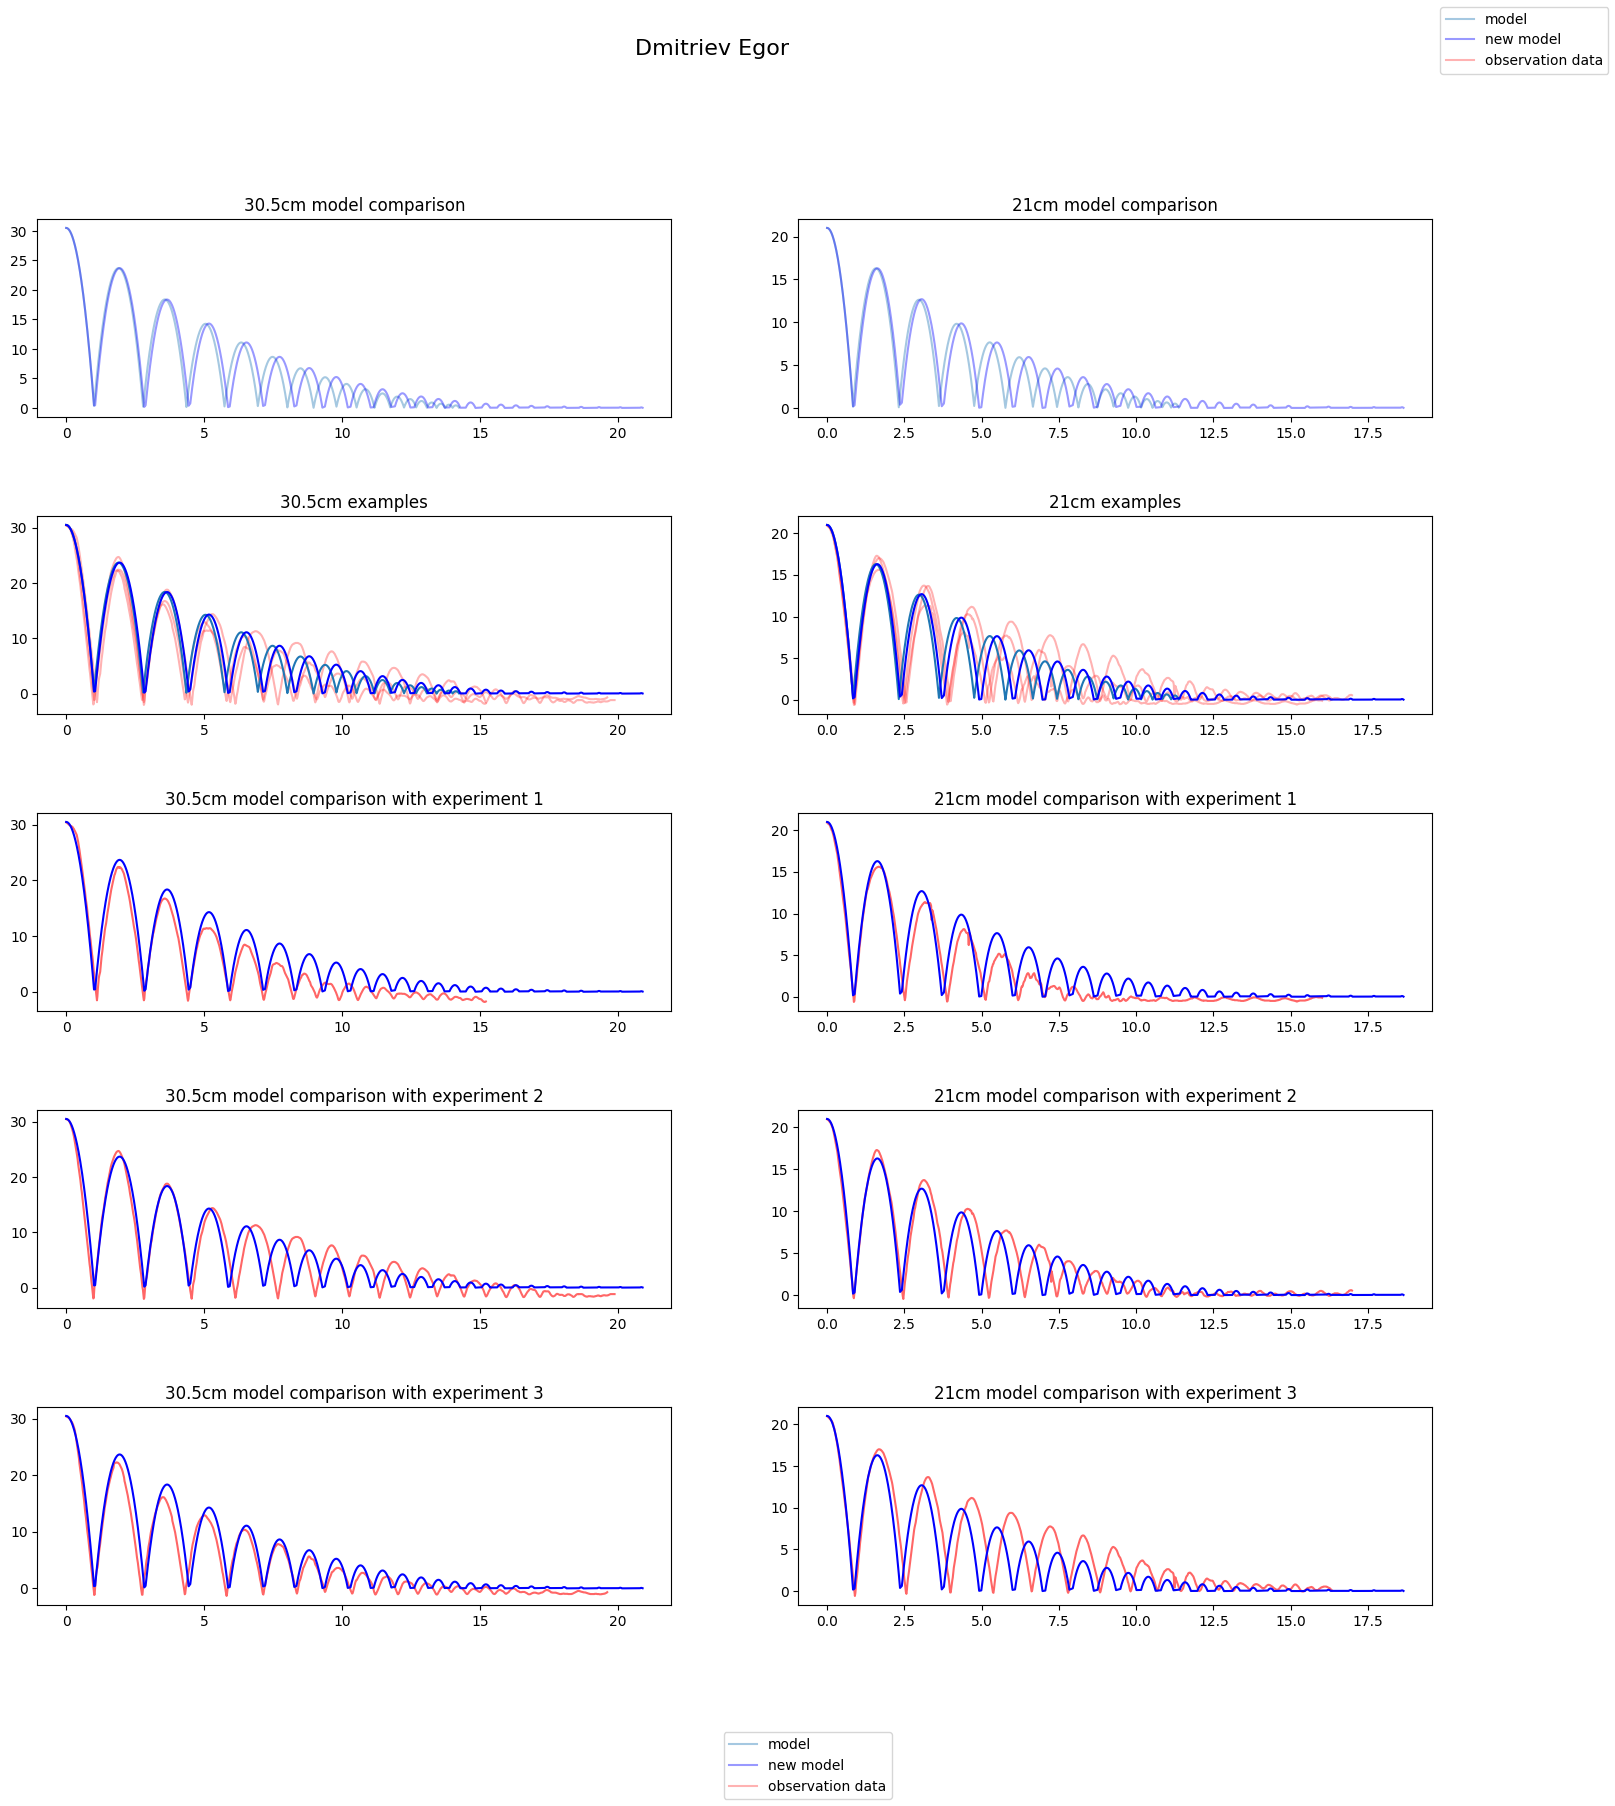

In [16]:
grid = plt.GridSpec(5, 2, wspace=0.2, hspace=0.5)
fig = plt.figure(figsize=(18, 18))
fig.suptitle("Dmitriev Egor", fontsize=16)

ax1 = plt.subplot(grid[0, 0], title=f'{L_30}cm model comparison')
ax3 = plt.subplot(grid[1, 0], title=f'{L_30}cm examples')
data_t, data_X = simulation(L_30)
data_t2, data_X2 = simulation2(L_30)

for i in range(0, 3):
    time_ref = np.array(range(len(real[5 - i]))) / 60
    ax3.plot(time_ref, L_30 - np.array(real[5 - i]), '-r', alpha=0.3)

ax3.plot(data_t, np.transpose(data_X)[:, 0] * R)
ax3.plot(data_t2, np.transpose(data_X2)[:, 0] * R, '-b')
ax1.plot(data_t, np.transpose(data_X)[:, 0] * R, alpha=0.4)
ax1.plot(data_t2, np.transpose(data_X2)[:, 0] * R, '-b', alpha=0.4)

ax2 = plt.subplot(grid[0, 1], title=f'{L_21}cm model comparison')
ax4 = plt.subplot(grid[1, 1], title=f'{L_21}cm examples')
data_t, data_X = simulation(L_21)
data_t2, data_X2 = simulation2(L_21)

for i in range(3, 6):
    time_ref = np.array(range(len(real[5 - i]))) / 60
    l_r, = ax4.plot(time_ref, L_21 - np.array(real[5 - i]), '-r', alpha=0.3)

ax4.plot(data_t, np.transpose(data_X)[:, 0] * R)
ax4.plot(data_t2, np.transpose(data_X2)[:, 0] * R, '-b')
l_b, = ax2.plot(data_t, np.transpose(data_X)[:, 0] * R, alpha=0.4)
l_b2, = ax2.plot(data_t2, np.transpose(data_X2)[:, 0] * R, '-b', alpha=0.4)

for i in range(3):
    data_t2, data_X2 = simulation2(L_30)
    axt = plt.subplot(grid[i + 2, 0], title=f'{L_30}cm model comparison with experiment {i + 1}')

    time_ref = np.array(range(len(real[5 - i]))) / 60
    axt.plot(time_ref, L_30 - np.array(real[5 - i]), '-r', alpha=0.6)
    axt.plot(data_t2, np.transpose(data_X2)[:, 0] * R, '-b')

for i in range(3):
    data_t2, data_X2 = simulation2(L_21)
    axt = plt.subplot(grid[i + 2, 1], title=f'{L_21}cm model comparison with experiment {i + 1}')

    time_ref = np.array(range(len(real[2 - i]))) / 60
    axt.plot(time_ref, L_21 - np.array(real[2 - i]), '-r', alpha=0.6)
    axt.plot(data_t2, np.transpose(data_X2)[:, 0] * R, '-b')

fig.legend([l_b, l_b2, l_r], ['model', 'new model', 'observation data'], loc='upper right')
fig.legend([l_b, l_b2, l_r], ['model', 'new model', 'observation data'], loc='lower center')
plt.show()

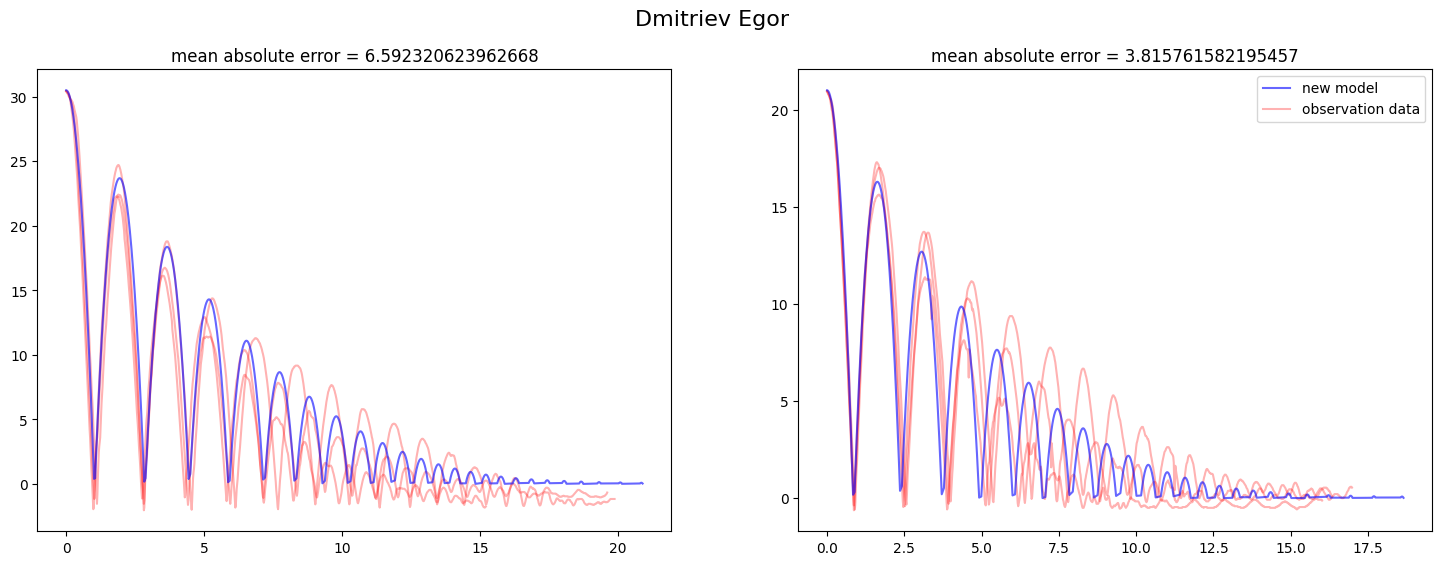

In [17]:
from sklearn.metrics import mean_absolute_error

grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.5)
fig = plt.figure(figsize=(18, 6))
fig.suptitle("Dmitriev Egor", fontsize=16)

data_t2, data_X2 = simulation2(L_30)

MAE = np.array(
    [mean_absolute_error(L_30 - np.array(real[5 - i]), np.transpose(data_X2)[:len(real[5 - i]), 0] * R) for i in
     range(0, 3)])
MAE_mean = sum(MAE) / 3

ax1 = plt.subplot(grid[:, 0], title=f'mean absolute error = {MAE_mean}')
for i in range(0, 3):
    time_ref = np.array(range(len(real[5 - i]))) / 60
    ax1.plot(time_ref, L_30 - np.array(real[5 - i]), '-r', alpha=0.3)
ax1.plot(data_t2, np.transpose(data_X2)[:, 0] * R, '-b', alpha=0.6)

data_t2, data_X2 = simulation2(L_21)

MAE = np.array(
    [mean_absolute_error(L_21 - np.array(real[5 - i]), np.transpose(data_X2)[:len(real[5 - i]), 0] * R) for i in
     range(3, 6)])
MAE_mean = sum(MAE) / 3

ax2 = plt.subplot(grid[:, 1], title=f'mean absolute error = {MAE_mean}')
for i in range(3, 6):
    time_ref = np.array(range(len(real[5 - i]))) / 60
    l_r, = ax2.plot(time_ref, L_21 - np.array(real[5 - i]), '-r', alpha=0.3)
l_b2, = ax2.plot(data_t2, np.transpose(data_X2)[:, 0] * R, '-b', alpha=0.6)

plt.legend([l_b2, l_r], ['new model', 'observation data'])
plt.show()

## Simulation with MSE and RMSE

In [24]:
from sklearn.metrics import mean_squared_error


def plot_sim_error(length: int):
    grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.5)
    fig = plt.figure(figsize=(18, 6))
    fig.suptitle("Errors", fontsize=16)

    t_axis, x_sim_axis = simulation2(length)
    n = np.min([len(real[i]) for i in range(3)])

    x_real = np.array([np.max(real[i]) - real[i][:n] for i in range(3)])
    x_sim = x_sim_axis.T[:n, 0]

    ax_mse = plt.subplot(grid[:, 0], title=f"MSE for yo-yo with {length}cm")
    ax_rmse = plt.subplot(grid[:, 1], title=f"RMSE for yo-yo with {length}cm")

    for i in range(3):
        err = mean_squared_error(x_real[i], x_sim)
        root_err = np.sqrt(err)
        print(f"Test {length}cm #{i + 1} > MSE {err}\t RMSE {root_err}")

        mse = np.power(x_real[i] - x_sim, 2)
        ax_mse.plot(mse / n, alpha=0.6, label=f"Test {i + 1}")
        ax_rmse.plot(np.sqrt(mse) / n, alpha=0.6, label=f"Test {i + 1}")

    ax_mse.set_xlabel("N")
    ax_mse.set_ylabel("MSE")
    ax_mse.grid()
    ax_mse.legend()

    ax_rmse.set_xlabel("N")
    ax_rmse.set_ylabel("RMSE")
    ax_rmse.grid()
    ax_rmse.legend()

    # plt.savefig(f"out/mse-{length}.jpg", format="jpeg")
    plt.show()

Test 21cm #1 > MSE 383.0621731777057	 RMSE 19.5719741768097
Test 21cm #2 > MSE 407.76521181729396	 RMSE 20.193197166800854
Test 21cm #3 > MSE 436.3688238945836	 RMSE 20.889442881383495


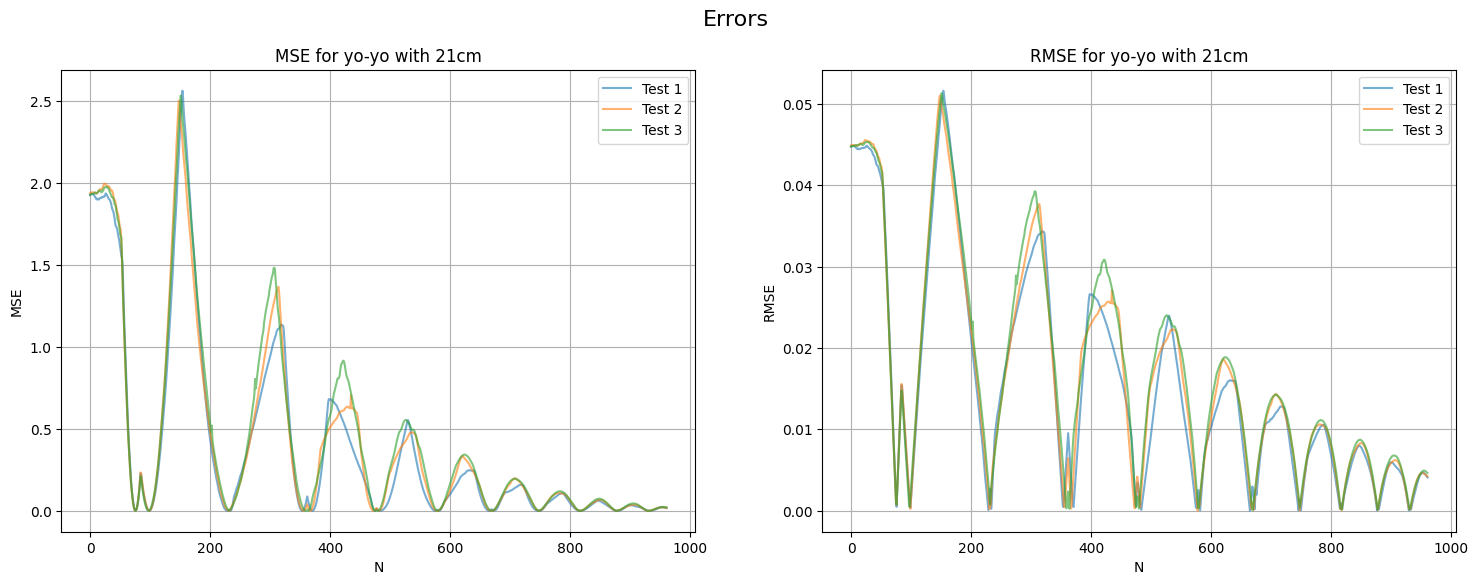

Test 30.5cm #1 > MSE 1199.005572613821	 RMSE 34.62665985355534
Test 30.5cm #2 > MSE 1242.4344835167165	 RMSE 35.248184116585584
Test 30.5cm #3 > MSE 1295.3502746738736	 RMSE 35.99097490585485


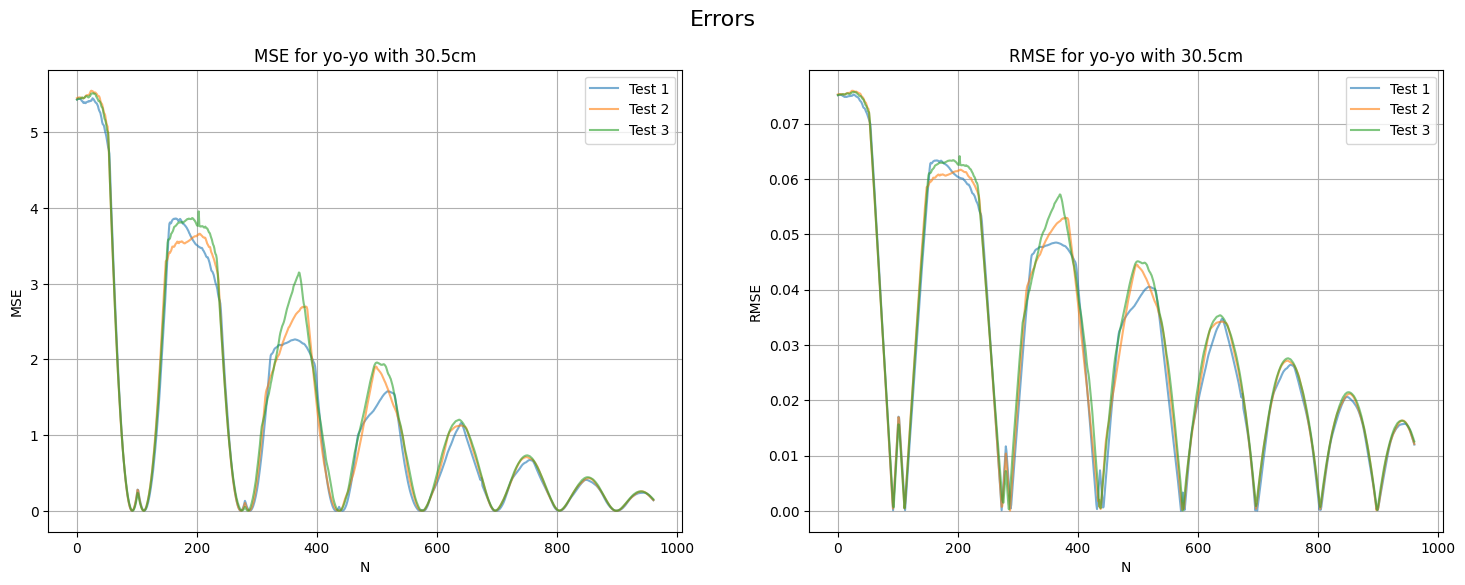

In [25]:
plot_sim_error(L_21)
plot_sim_error(L_30)